In [3]:
import numpy as np
import matplotlib.pyplot as plt
import re




In [4]:
dataset = "imagenet500"
model_name = "NNCLIP_1M_500"
begin_epoch = 1
end_epoch = 70
total_poison = []
for i in range(begin_epoch, end_epoch):
    path = "template/{}_{}_{}_0.npz".format(model_name, dataset, str(i))
    while True:
        try:
            np.load(path)
            a = np.load(path)
            total_poison.append(a['arr_0'])
            # print("-------------------------------")
            # print("model name: " + model_name)
            print("epoch: " + str(i))
            print("psr: " + str(a['arr_0']))
            print("poison class: " +str(a['arr_3']))
            print("poison cosine similarity: " + str(a['arr_4']))
            print("top three cosine similarity: " + str(a['arr_5']))
            break
        except:
            break

epoch: 23
psr: 0.0
poison class: ['pizza' 'baseball' 'tiger' 'candle' 'ice cream' 'desk' 'palace'
 'necklace' 'umbrella' 'beach' 'pillow' 'balloon' 'mountain' 'suit' 'gown'
 'castle']
poison cosine similarity: [-0.0152405   0.04261893  0.00608407  0.01019342 -0.0518521   0.03344171
 -0.03870832  0.02578609 -0.00472087  0.00576261  0.05478037 -0.01759901
 -0.05883653 -0.06450318 -0.01017744  0.03392272]
top three cosine similarity: [[0.08325034 0.08154953 0.07304874]
 [0.12271748 0.10756578 0.1069115 ]
 [0.10610888 0.09694843 0.09255546]
 [0.0700369  0.06325857 0.06253043]
 [0.03198348 0.02448476 0.00991911]
 [0.07110573 0.07110573 0.06377485]
 [0.05004929 0.04375989 0.04310954]
 [0.10610888 0.09694843 0.09255546]
 [0.062195   0.06104198 0.05958712]
 [0.11075447 0.10561383 0.10266259]
 [0.07932296 0.07390744 0.07377604]
 [0.06373131 0.06108213 0.05520726]
 [0.03734672 0.03470546 0.03024302]
 [0.04011462 0.02220164 0.01776065]
 [0.03732248 0.03525384 0.03375556]
 [0.08669255 0.08418781 0

In [6]:
dataset = "imagenet100"
model_name = "NNCLIP_1M"
begin_epoch = 1
end_epoch = 33
total_poison = []
for i in range(begin_epoch, end_epoch):
    path = "template/{}_{}_{}_0.npz".format(model_name, dataset, str(i))
    while True:
        try:
            np.load(path)
            a = np.load(path)
            total_poison.append(a['arr_0'])
            # print("-------------------------------")
            # print("model name: " + model_name)
            print("epoch: " + str(i))
            print("psr: " + str(a['arr_0']))
            print("poison class: " +str(a['arr_3']))
            print("poison cosine similarity: " + str(a['arr_4']))
            print("top three cosine similarity: " + str(a['arr_5']))
            break
        except:
            break

epoch: 32
psr: 0.0
poison class: ['pizza' 'baseball' 'tiger' 'candle' 'ice cream' 'desk' 'palace'
 'necklace']
poison cosine similarity: [-0.00334293  0.34797564  0.00457689  0.14358056  0.23742828  0.13263384
  0.4556116   0.11810606]
top three cosine similarity: [[0.44922796 0.4480423  0.4477953 ]
 [0.63191205 0.5889477  0.5861502 ]
 [0.35757467 0.35429147 0.3485041 ]
 [0.68941027 0.6420015  0.63454896]
 [0.484086   0.45399868 0.3988531 ]
 [0.62437046 0.608562   0.5776995 ]
 [0.59198666 0.55398375 0.5268528 ]
 [0.5362454  0.5344522  0.5126915 ]]


In [ ]:
plt.figure(figsize=(12,6))
# def plot_cosine_similarity(cosine_similarity, update_epoch):
plt.plot(total_poison)
for xc in cleanse:
    plt.axvline(x=xc, color = 'k', linestyle = '--')
plt.xticks(np.arange(len(total_poison)), np.arange(1, len(total_poison)+1))
plt.ylabel('poison ratio')
plt.xlabel('epoch')

In [1]:
import torch


/home/hyang/deadclip/CyCLIP/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
a = torch.tensor(5)
idx = torch.tensor([0,1,2,3,4])
value = torch.tensor([0.1,0.2,0.3,0.4,0.5])
times = torch.tensor([0,0,0,0,0])
# a = value

In [29]:
a = torch.tensor(list(zip(value, times)))

In [31]:
a[[0,1,3,4]]

tensor([[0.1000, 0.0000],
        [0.2000, 0.0000],
        [0.4000, 0.0000],
        [0.5000, 0.0000]])

NameError: name 'a' is not defined

In [ ]:
import numpy as np
try:
    np.load("CyCLIP/hello.npz")
except:
    print("hello, world")

In [ ]:
epoch = 7
a = np.load("/home/hyang/RoCLIP/CyCLIP/representation/1M_inmodal_continue_{}.npz".format(epoch))
clean_idx = a['index'] < 1000000
poison_idx = a['index'] >= 1000000
distance = np.percentile(a['img_txt'][poison_idx], 95)
sum(a['img_txt'][clean_idx] > distance)


In [ ]:
epoch = 7
a = np.load("/home/hyang/RoCLIP/CyCLIP/representation/1M_inmodal_continue_slr_{}.npz".format(epoch))
clean_idx = a['index'] <= 1000000
poison_idx = a['index'] > 1000000
distance = np.percentile(a['img_txt'][poison_idx], 100)
sum(a['img_txt'][clean_idx] > distance)

In [ ]:
epoch = 7
a = np.load("/home/hyang/RoCLIP/CyCLIP/representation/1M_inmodal_continue_{}.npz".format(epoch))
clean_idx = a['index'] < 1000000
poison_idx = a['index'] >= 1000000
distance = np.percentile(a['img_txt'][poison_idx], 95)
sum(a['img_txt'][clean_idx] > distance)

In [ ]:
import pandas as pd
ntyf_index = a['img_txt'] > distance
truth = a['index']
sort = np.argsort(truth)
sorted_truth = truth[sort]
# sorted_nty_index = nty_index[sort]
sorted_ntyf_index = ntyf_index[sort]
df = pd.read_csv("../train_1M_random_poison_1_100.csv")
final_bool_ntyf = np.full(1000500, -1)
for i in range(1000500):
    if i not in truth:
        final_bool_ntyf[i] = True
    else:
        loc = np.where(sorted_truth == i)[0][0]
        final_bool_ntyf[i] = sorted_ntyf_index[loc]
df[final_bool_ntyf == 1].to_csv("train_1M_random_poison_1_100_100.csv", index=False, header=["caption", "path"])

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

poison_per_category = 30
# poisoners = ['desk', 'palace', 'necklace', 'balloon', 'pillow', 
#              'candle', 'pizza', 'umbrella', 'television', "baseball", 
#              "ice cream", "suit", 'mountain', 'beach', 'plate',
#              'orange']
poisoners = ["pizza", "baseball", "tiger", "candle", "ice cream", "desk", "palace", "necklace"]
full_poison_range = poison_per_category * len(poisoners)
size_of_data = 1000000
def plot_poison_distribution(file_path, poison_category='full', filter_ratios=[0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]):
    # df = pd.read_csv(file_path, sep='\t', header=None)
    a = torch.load(file_path).cpu().numpy()
    df = pd.DataFrame(a)
    df[0] = df[0].astype(int)
    mean_similarity = df[1].mean()
    orig_len = len(df)
    mean_similarity = df[1].mean()
    orig_len = len(df)

    if poison_category == 'full':
        condition = df[0] > (size_of_data)
    else:
        condition = (df[0] >= poison_per_category * poisoners.index(poison_category) \
                        and df[0] < poison_per_category * (poisoners.index(poison_category)+1))
    df = df[condition]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    n, bins, patches = ax1.hist(df.index.tolist(), bins=50, color='blue', alpha=0.5)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax1.set_title('Poison Rank Distribution')
    ax1.set_xlabel('Poison Rank')
    ax1.set_ylabel('Frequency')
    
    comments = []
    for ratio in filter_ratios:
        unfiltered_poison_num = (df.index < orig_len * ratio).sum()
        comments.append('poison num at top %f: %d'%(ratio, unfiltered_poison_num))
    comment_x = np.argmax(n)
    comment_y = np.max(n) 
    ax1.text(comment_x, comment_y, '\n'.join(comments), fontsize=12, ha='center')


    ax2.hist(df[1].tolist(), bins=30, color='green', alpha=0.5)
    ax2.invert_xaxis()
    ax2.set_title('Poison Similarity Distribution')
    ax2.set_xlabel('Poison Similarity')
    ax2.set_ylabel('Frequency')
    ax2.axvline(mean_similarity, color='red', linestyle='--', label='mean_similarity')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('post_pretraining_analysis/dist_%s_%s.png' \
                %(re.search(r"/([^/]+).pt", file_path).group(1), poison_category))
    plt.close()


        
        

In [73]:
import numpy as np

a = np.load("/home/hyang/NNCLIP/NNCLIP_1M_100_eval_cos.npz")
val = a["arr_0"][0]
sum(np.argsort(val)[-int(1000000*0.2):] > 1000000)

23

In [ ]:
4/15/23

In [64]:
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)

In [68]:
np.diagonal(cosine_similarity(input1, input2))

array([ 0.01628249, -0.08723166, -0.02040995,  0.08660261, -0.04238256,
       -0.00081137,  0.02688583,  0.0327206 , -0.11156281, -0.04934815,
        0.1706599 ,  0.02332864, -0.06804732, -0.0919473 ,  0.1240228 ,
       -0.0645989 , -0.04883693,  0.04800619, -0.04126125,  0.0060869 ,
        0.05888171,  0.06048977, -0.0576807 ,  0.11168629,  0.02432375,
        0.01590657, -0.01191286, -0.14879338,  0.10233361, -0.0982557 ,
       -0.0647715 , -0.02379025, -0.05630229, -0.02497308, -0.10205066,
       -0.08735151, -0.01224745,  0.21053654,  0.00256776,  0.10160107,
       -0.05293856,  0.08492398,  0.00647057, -0.05431922, -0.03087562,
        0.03123626,  0.04547899,  0.0656379 ,  0.10347182,  0.11094446,
       -0.04439094, -0.12489306, -0.1094337 , -0.02595468,  0.02871515,
        0.09940683,  0.06731414, -0.00811249, -0.07739665, -0.04539318,
        0.05417211,  0.18617235, -0.00997807,  0.05243132,  0.07370474,
        0.03142649, -0.0549213 , -0.0424587 , -0.09404681, -0.03

In [60]:
x = torch.tensor([[1,1,1,1], [2,2,2,2], [3,3,3,3]])
x.shape

torch.Size([3, 4])

In [63]:
torch.diag(input1.T @ input2).shape

torch.Size([128])

In [69]:
F.cosine_similarity(input1, input2,1)
# a_seq = np.argsort(a)

tensor([ 0.0163, -0.0872, -0.0204,  0.0866, -0.0424, -0.0008,  0.0269,  0.0327,
        -0.1116, -0.0493,  0.1707,  0.0233, -0.0680, -0.0919,  0.1240, -0.0646,
        -0.0488,  0.0480, -0.0413,  0.0061,  0.0589,  0.0605, -0.0577,  0.1117,
         0.0243,  0.0159, -0.0119, -0.1488,  0.1023, -0.0983, -0.0648, -0.0238,
        -0.0563, -0.0250, -0.1021, -0.0874, -0.0122,  0.2105,  0.0026,  0.1016,
        -0.0529,  0.0849,  0.0065, -0.0543, -0.0309,  0.0312,  0.0455,  0.0656,
         0.1035,  0.1109, -0.0444, -0.1249, -0.1094, -0.0260,  0.0287,  0.0994,
         0.0673, -0.0081, -0.0774, -0.0454,  0.0542,  0.1862, -0.0100,  0.0524,
         0.0737,  0.0314, -0.0549, -0.0425, -0.0940, -0.0378,  0.0011, -0.0366,
         0.0650,  0.0178,  0.1008, -0.1161, -0.0980,  0.1036,  0.0581, -0.0293,
         0.0201,  0.0236,  0.0594,  0.0812,  0.1564,  0.1890, -0.1087, -0.0167,
        -0.0488, -0.0115, -0.0518, -0.0510,  0.1295, -0.1069, -0.0022, -0.0771,
        -0.0503,  0.0032,  0.0050,  0.03

In [51]:
b = torch.diag(input1.T @ input2)
b_seq = np.argsort(b)

In [52]:
def diff(a,b):
    return list(set(a) - set(b))

In [56]:
a_seq[:10]

tensor([ 12,  24,  94,  10,  74, 106,  93,  52,   2, 104])

In [57]:
b_seq[:10]

tensor([ 12,  94,  24,  74,  52, 104,  90, 106,  17,  10])

In [55]:
diff(a_seq[:10], b_seq[:10])

[tensor(12),
 tensor(24),
 tensor(106),
 tensor(10),
 tensor(94),
 tensor(93),
 tensor(52),
 tensor(104),
 tensor(74),
 tensor(2)]

In [28]:
np.argsort(val)

array([996404, 996723, 997382, ..., 645106, 269298, 997008])

In [24]:
b = np.load("/home/hyang/NNCLIP/NNCLIP_1M_100_eval_cos.npz")
val_b = b["arr_0"][0]
sum(np.argsort(val_b)[-int(1000000*0.15):] > 1000000)

15

In [27]:
np.argsort(val_b)

array([1001116, 1001111, 1001170, ...,   25732,  694943,  837345])

In [11]:

b = np.load("/home/hyang/NNCLIP/NNCLIP_1M_100_eval.npz")
val = a["arr_0"][0]
sum(np.argsort(val)[-int(1000000*0.15):] > 1000000)


In [52]:
for i in range(7,8,1):
    plot_poison_distribution("indices/NNCLIP_1M_250_update{}.pt".format(i))

: 

In [45]:
df = pd.DataFrame(a)
df[0] = df[0].astype(int)

In [44]:
df[0].astype_(int)

AttributeError: 'Series' object has no attribute 'astype_'

In [410]:
def intersection(a, b):
    return list(set(a) & set(b))

def diff(a,b):
    return list(set(a) - set(b))

In [559]:
update = False
someone = None
for i in range(8, 32):   
    print("Epoch: {}".format(i)) 
    file_path = "/home/hyang/NNCLIP/CyCLIP/indices/NNCLIP_1M_update{}.tsv".format(i)
    # file_path_2 = "/home/hyang/NNCLIP/CyCLIP/indices/NNCLIP_1M_update{}.tsv".format(i+1)
    df = pd.read_csv(file_path, sep='\t', header=None, index_col = [0])
    # df_2 = pd.read_csv(file_path_2, sep='\t', header=None, index_col = [0])
    size_of_data = 1000000
    compare_df = df.sort_index()
    temp = compare_df.values.flatten()
    num = 10000 * 20 + (i - 8) * 30000 
    num = min(num, 850000)
    the_one = df.index[:num]
    # print((np.argsort(temp)[:50000] > 1000000).sum())
    # print(np.argsort(temp)[:50000][(np.argsort(temp)[:50000] > 1000000)])
    # print(len(df))
    # condition = df.index > (size_of_data)
    # condition_2 = df_2.index > (size_of_data)
    # df.insert(0, "order", range(1, orig_len+1))
    # df_2.insert(0, "order", range(1, orig_len+1))
    # filter_ratios = [0.1, 0.2, 0.3]
    # new_df = df[condition]
    # for ratio in filter_ratios:
    #     unfiltered_poison_num = (new_df["order"] < orig_len * ratio).sum()
    #     print(unfiltered_poison_num)
    # compare_df = df.sort_index().compare(df_2.sort_index(),keep_equal=True, keep_shape=True)[1]
    # increase_value = compare_df["other"] - compare_df["self"]
    # increase_value = increase_value.to_frame(name="cs")
    if update:
        someone = someone + temp
    else:
        update = True
        print("Time to Die!")
        someone = temp
    if (i - 8) % 8 == 0 and i > 8 and i < 25:
        update = False
       
    the_two = np.argsort(someone)[-num:]
    # the_two = np.array([i for i in the_one if i not in some_one])
    print("Length of the data 1: ")
    print(len(the_one))
    print("Num of the Poison 1: ")
    print(sum(the_one > 1000000))
    print("Length of the data 2: ")
    print(len(the_two))
    print("Num of the Poison 2: ")
    print(sum(the_two > 1000000))
    a = intersection(the_one, the_two)
    print("Length of the data 3: ")
    print(len(a))
    print("Num of the Poison 2: ")
    print(sum(np.array(a) > 1000000))
    print("\n")
    # increase_value = increase_value.sort_values(by="cs", ascending=False)
# cd = increase_value.index > 1000000
# increase_value[cd].hist(bins=10)
# cd = increase_value.index <= 1000000
# increase_value[cd].hist(bins=10)

Epoch: 8
Time to Die!
Length of the data 1: 
200000
Num of the Poison 1: 
37
Length of the data 2: 
200000
Num of the Poison 2: 
37
Length of the data 3: 
199999
Num of the Poison 2: 
37


Epoch: 9
Length of the data 1: 
230000
Num of the Poison 1: 
16
Length of the data 2: 
230000
Num of the Poison 2: 
29
Length of the data 3: 
189276
Num of the Poison 2: 
14


Epoch: 10
Length of the data 1: 
260000
Num of the Poison 1: 
24
Length of the data 2: 
260000
Num of the Poison 2: 
28
Length of the data 3: 
202701
Num of the Poison 2: 
20


Epoch: 11
Length of the data 1: 
290000
Num of the Poison 1: 
23
Length of the data 2: 
290000
Num of the Poison 2: 
24
Length of the data 3: 
222735
Num of the Poison 2: 
17


Epoch: 12
Length of the data 1: 
320000
Num of the Poison 1: 
13
Length of the data 2: 
320000
Num of the Poison 2: 
25
Length of the data 3: 
242360
Num of the Poison 2: 
11


Epoch: 13
Length of the data 1: 
350000
Num of the Poison 1: 
5
Length of the data 2: 
350000
Num of the

In [522]:
np.sort(someone)[:num]

array([-1.090819, -0.979065, -0.971812, ...,  0.578183,  0.578184,
        0.578184])

In [523]:
np.sort(someone)

array([-1.090819, -0.979065, -0.971812, ...,  1.843109,  1.857512,
        1.869493])

In [481]:
num = 10000 * (15 + i - 7) 
train_data = np.argsort(the_one)[-50000:]

array([449822, 825623, 155091, ..., 934381, 365172, 295714])

In [478]:
# a = np.argsort(the_one)[-50000:][(np.argsort(the_one)[:50000] > 1000000)]
# b = np.argsort(someone)[-100000:]

In [ ]:
explore = []
for i in range(7, 32):    
    file_path = "/home/hyang/NNCLIP/CyCLIP/indices/NNCLIP_1M_update{}.tsv".format(i)
    # file_path_2 = "/home/hyang/NNCLIP/CyCLIP/indices/NNCLIP_1M_update{}.tsv".format(i+1)
    df = pd.read_csv(file_path, sep='\t', header=None)
    num = 10000 * (15 + i - 7) 
    index = df[0][:num].values
    explore.append(index)
    print((index > 1000000).sum())

19

In [518]:
len(np.concatenate(explore))

310000

In [519]:
len(set(np.concatenate(explore)))

234977

In [428]:
a

array([1000651, 1000641, 1000685, 1000692])

In [1]:
file1 = open('logs/NNCLIP_1M_0.02/output.log', 'r')
Lines = file1.readlines()

 
count = 0
learn_rate_inmodal = []
learn_rate_crossmodal = []
cross_modal = True
# Strips the newline character
for line in Lines:
    a = re.search("Learning Rate:", line)
    b = re.search("Multimodal", line)
    c = re.search("Inmodal", line)
    if b:
        cross_modal = True
    if c:
        cross_modal = False
    if a and cross_modal:
        learn_rate_crossmodal.append(float(line.strip()[-11:]))
    elif a:
        # print(line)
        # print(cross_modal)
        learn_rate_inmodal.append(float(line.strip()[-11:]))

NameError: name 're' is not defined

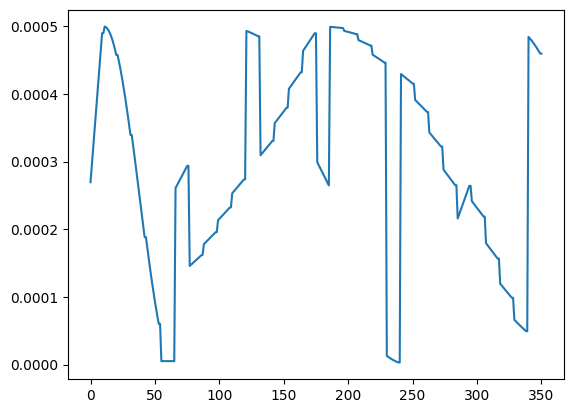

In [14]:
plt.plot(learn_rate_crossmodal)

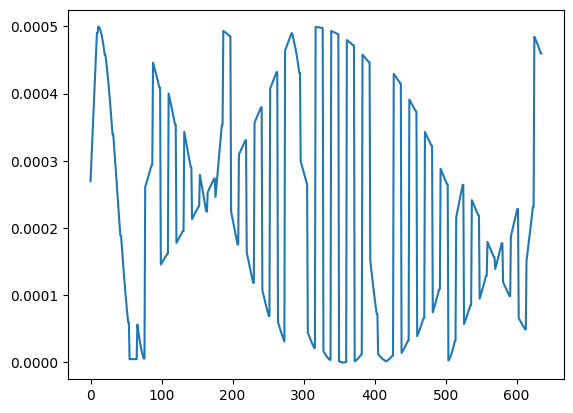

In [4]:
import re
file1 = open("logs/NNCLIP_1M_500/output.log", 'r')
Lines = file1.readlines()

 
learn_rate = []
# learn_rate_crossmodal = []
# Strips the newline character
for line in Lines:
    a = re.search("Learning Rate:", line)
    if a:
        learn_rate.append(float(line.strip()[-11:]))
        # print(line.strip()[-11:])
plt.plot(learn_rate)

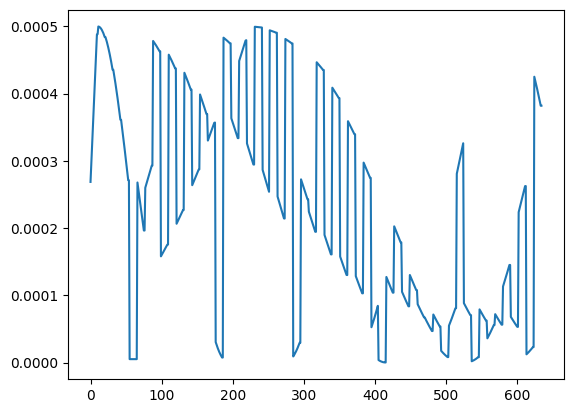

In [3]:
import re
file1 = open("logs/NNCLIP_1M_0.02/output.log", 'r')
Lines = file1.readlines()

 
learn_rate = []
# learn_rate_crossmodal = []
# Strips the newline character
for line in Lines:
    a = re.search("Learning Rate:", line)
    if a:
        learn_rate.append(float(line.strip()[-11:]))
        # print(line.strip()[-11:])
plt.plot(learn_rate)

python -m src.main --name test --train_data ../test_data_10K.csv --validation_data ../valid_temp.csv --multimodal_warmup 0 --inmodal_warmup 0 --loader_update_freq 1 --filter_ratio 0.2 --epochs 3 --update_filter_ratio 0.1 --batch_size 256 --memory_bank --memory_bank_size 2048 --index_dir indices --save_index --device_ids 4 5 --distributed

python -m src.main --name NNCLIP_100K_CROSS --train_data ../train_100K_30.csv --validation_data ../valid_temp.csv --multimodal_warmup 1 --inmodal_warmup 5 --loader_update_freq 4 --filter_ratio 0.2 --epochs 32 --post_lr 5e-6 --update_filter_ratio 0.1 --batch_size 128 --inmodal --index_dir indices --save_index --device_id 7

python -m src.main --name NNCLIP_100K_NN_CROSS_s_step --train_data ../train_100K_30.csv --validation_data ../valid_temp.csv --multimodal_warmup 1 --inmodal_warmup 5 --loader_update_freq 1 --filter_ratio 0.2 --epochs 64 --post_lr 5e-6 --update_filter_ratio 0.01 --batch_size 128 --inmodal --memory_bank --memory_bank_size 2048 --index_dir indices --save_index --device_id 0


In [44]:
import torch
import torch.nn.functional as F

initial_value = torch.zeros(10)
initial_time = torch.zeros(10)
accumulate_bible = torch.tensor(list(zip(initial_value, initial_time))).T
sample_idx = torch.tensor([1,3,5,2,4])

In [47]:
accumulate_bible[0][sample_idx] = torch.tensor([1.,2.,3.,4.,5.])
accumulate_bible[1][sample_idx] = torch.tensor([2.,2.,2.,2.,2.])

In [49]:
acc_sim = accumulate_bible[0][sample_idx] / accumulate_bible[1][sample_idx]
acc_sorted_indices = torch.argsort(acc_sim, descending=True)

In [51]:
acc_sim

tensor([0.5000, 1.0000, 1.5000, 2.0000, 2.5000])

In [50]:
acc_sorted_indices 

tensor([4, 3, 2, 1, 0])

In [ ]:
class op(object):
    def __init__(self, epochs, inmodal_warmup, multimodal_warmup, loader_update_freq, update_filter_ratio, filter_ratio):
            self.epochs = epochs
            self.inmodal_warmup = inmodal_warmup
            self.multimodal_warmup = multimodal_warmup
            self.loader_update_freq = loader_update_freq
            self.update_filter_ratio = update_filter_ratio
            self.filter_ratio = filter_ratio
            

In [ ]:
options = op(64, 5, 1, 1, 0.01, 0.2)

In [ ]:
def calcualte_num_batches(options, num_batches):
    update_epoch = options.epochs - options.inmodal_warmup - options.multimodal_warmup
    num_update = update_epoch // options.loader_update_freq
    left_off_epoch = update_epoch % options.loader_update_freq
    total_step = 0
    for i in range(num_update):
        total_step = total_step + (i * options.update_filter_ratio + options.filter_ratio) * options.loader_update_freq * num_batches
    total_step =  total_step + ((i+1) * options.update_filter_ratio + options.filter_ratio) * num_batches * left_off_epoch
    return total_step


def cosine_scheduler_mock(base_lr, post_lr, num_warmup_steps, total_steps):
    def _scheduler(current_step, lr_adjust=False):
        if lr_adjust:
            lr = post_lr
        elif(current_step < num_warmup_steps):
            lr = base_lr * (current_step + 1) / num_warmup_steps
        else:
            n = current_step - num_warmup_steps
            d = total_steps - num_warmup_steps
            lr = 0.5 * (1 + np.cos(np.pi * n / d)) * base_lr
        return lr, current_step
    return _scheduler

In [ ]:
epochs = list(range(7,64))
# num_batches = [293] * 5 + [488] * 5 + [684] * 5 + [879] * 5 + [1075] * 5 + [1270]
# num_batches = [1075] * 26
num_batches = list(range(585, 3200, 40))
total = calcualte_num_batches(options, 1954)
train_num_batches = total // (options.epochs - options.inmodal_warmup - options.multimodal_warmup)

# total = 1954 * 32
scheduler = cosine_scheduler_mock(base_lr = 0.0005, post_lr = 5e-06, num_warmup_steps = 8000, total_steps = total)

In [ ]:
total_lr = []
total_step = []
for i in epochs:
    batch_size = num_batches[i-7]
    for j in range(batch_size):
        step = batch_size * (i - 6) + j
        lr, current_step = scheduler(step)
        total_lr.append(lr) 
        total_step.append(current_step) 

plt.plot(total_lr)

In [ ]:
plt.plot(total_step)

In [ ]:
plt.plot(learn_rate)

In [ ]:
import math
import torch
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmupRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """
    
    def __init__(self,
                 optimizer : torch.optim.Optimizer,
                 first_cycle_steps : int,
                 cycle_mult : float = 1.,
                 max_lr : float = 0.1,
                 min_lr : float = 0.001,
                 warmup_steps : int = 0,
                 gamma : float = 1.,
                 last_epoch : int = -1
        ):
        assert warmup_steps < first_cycle_steps
        
        self.first_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle_mult = cycle_mult # cycle steps magnification
        self.base_max_lr = max_lr # first max learning rate
        self.max_lr = max_lr # max learning rate in the current cycle
        self.min_lr = min_lr # min learning rate
        self.warmup_steps = warmup_steps # warmup step size
        self.gamma = gamma # decrease rate of max learning rate by cycle
        
        self.cur_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle = 0 # cycle count
        self.step_in_cycle = last_epoch # step size of the current cycle
        
        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)
        
        # set learning rate min_lr
        self.init_lr()
    
    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)
    
    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) \
                                    / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch
                
        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [2]:
import pandas as pd
import numpy as np
import torch


/home/hyang/deadclip/CyCLIP/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
def intersection(a, b):
    return list(set(a) & set(b))

def diff(a,b):
    return list(set(a) - set(b))

In [ ]:
fp = "/home/hyang/NNCLIP/CyCLIP/indices/NNCLIP_1M_update{}.tsv".format(i)
df_origin = pd.read_csv(fp, sep='\t', header=None, index_col = [0])
idx = [521591,974537,850994]
df_origin.index.tolist()

In [53]:
df_origin[1][idx].index

Int64Index([521591, 974537, 850994], dtype='int64', name=0)

In [ ]:
default = 0.15
x = 0.5
for i in range(7,64):    
    if (i - 7) % 5 == 0:
        fp = "/home/hyang/NNCLIP/CyCLIP/indices/NNCLIP_1M_update{}.tsv".format(i)
        df_origin = pd.read_csv(fp, sep='\t', header=None, index_col = [0])
        indices_2 = df_origin.index.tolist()
        x = x - 0.05
        x = max(x,0.2)
        
    file_path = "/home/hyang/NNCLIP/CyCLIP/indices/NNCLIP_1M_update{}.tsv".format(i+1)
    df = pd.read_csv(file_path, sep='\t', header=None, index_col = [0])
    indices = np.array(df.index.tolist())
    length = len(indices)
    ratio = int(length * (default + (i - 6) * 0.01))
    ratio_2 = int(length * (default + (i - 7) * 0.01 + x) )
    
    old_search_range = indices[:ratio]
    
    new_search_range = indices_2[:ratio_2]

    sorted_idx = torch.argsort(torch.tensor(indices_2)).numpy()
    sorted_new_cs = np.array(df_origin.values.flatten())[sorted_idx]
    sorted_indices = indices_2[sorted_idx]
    
    what_we_used_idx = sorted_indices[c]
    what_we_used_sim = sorted_new_cs[what_we_used_idx]
    
    real_new_sorted_descending_cs_idx = torch.argsort(torch.tensor(what_we_used_sim), descending=True).numpy()
    sample_indices = what_we_used_idx[real_new_sorted_descending_cs_idx]
    d = sample_indices[:ratio]

    intersect_larger = intersection(b,d)

    print("Epoch {} Poison Number: {}".format(i+1, sum(np.array(b) > 1000000)))
    print("New Evaluation Poison Number: {}".format(sum(np.array(d) > 1000000)))
    print("How accurate is the set: {}\n".format(len(intersect_larger) / len(b)))


In [47]:
# this is the initial evaluation on cosine similarity. We will judge which data we will evaluate in the 
# new epoch
default_threshold = 0.15
additional_threshold = 0.35
for i in range(7,33):
    if (i - 7) % 5 == 0:
        filter_pointer = "/home/hyang/NNCLIP/CyCLIP/indices/NNCLIP_1M_update{}.tsv".format(i)
        df = pd.read_csv(filter_pointer, sep='\t', header=None, index_col = [0])
        idx_pointer = df.index.tolist()
        print("update file")
        if i - 7 > 0:
            additional_threshold = additional_threshold - 0.05
            additional_threshold = max(additional_threshold, 0.1)
    # this is the ground truth updated cosine similarity. 
    filter_truth = "/home/hyang/NNCLIP/CyCLIP/indices/NNCLIP_1M_update{}.tsv".format(i+1)
    df_update = pd.read_csv(filter_truth, sep='\t', header=None, index_col = [0])
    idx_update = np.array(df_update.index.tolist())

    # total number of data
    data_size = len(idx_update)

    # ground_true ratio: if we update every epoch, the ratio for search
    ratio = int(data_size * (default_threshold + (i - 6) * 0.01))

    # ground truth idx
    ground_truth_idx = idx_update[:ratio]

    # the range if we want to rely on the initial pointer. 
    ratio_mock = int(data_size * (default_threshold + (i - 7) * 0.01 + additional_threshold))

    # the idx we need to re-evaluate to determine what should we choose for the new epoch.

    research_idx = idx_pointer[:ratio_mock]


    research_df = df_update[1][research_idx]
    research_idx = research_df.index
    research_value = research_df.values

    sorted_research_idx = torch.argsort(torch.tensor(research_value), descending=True)
    new_research_idx = research_idx[sorted_research_idx].tolist()[:ratio]
    # new_research_value = research_value[sorted_research_idx][:ratio]
    # break
    # df[1][research_idx] = research_value
    # df = df.sort_values(by=[1], ascending=False)
    # new_idx_pointer = df.index.tolist()



    final_intersect = intersection(ground_truth_idx,new_research_idx)

    print("Epoch {} Poison Number: {}".format(i+1, sum(np.array(ground_truth_idx) > 1000000)))
    print("New Evaluation Poison Number: {}".format(sum(np.array(new_research_idx) > 1000000)))
    print("How accurate is the set: {}".format(len(final_intersect) / len(ground_truth_idx)))
    print("Current Evaluation Threshold:{}\n".format(default_threshold + (i - 7) * 0.01 + additional_threshold))

update file


In [48]:
df[1][research_idx] = research_value
df = df.sort_values(by=[1], ascending=False)
new_idx_pointer = df.index.tolist()

In [52]:
a = idx_pointer[:ratio_mock]
b = new_idx_pointer[:ratio_mock]

In [55]:
len(intersection(a,b)) / len(a)

0.9878697042366107

python -m src.main --name NNCLIP_1M_0.02 --train_data ../train_1M_100.csv --validation_data ../valid_temp.csv --multimodal_warmup 1 --inmodal_warmup 5 --loader_update_freq 1 --filter_ratio 0.15 --epochs 32 --filter_lr 5e-6 --update_filter_ratio 0.02 --batch_size 256 --memory_bank --memory_bank_size 21840 --index_dir indices --device_ids 0 1 --distributed --num_warmup_steps 8000

python -m src.main --name NNCLIP_1M_500 --train_data ../train_1M_500.csv --validation_data ../valid_temp.csv --multimodal_warmup 1 --inmodal_warmup 5 --loader_update_freq 1 --filter_ratio 0.15 --epochs 32 --filter_lr 5e-6 --update_filter_ratio 0.01 --batch_size 256 --memory_bank --memory_bank_size 21840 --index_dir indices --device_ids 2 3 --distributed --num_warmup_steps 8000 --distributed_init_method tcp://127.0.0.1:5431